In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NOTA IMPORTANTE: AQUÍ SÓLO SE MUESTRA EL CÓDIGO NECESARIO PARA APLICAR RANDOM FOREST.

# RECUÉRDESE LA IMPORTANCIA DE LOS PASOS A SEGUIR PARA IMPLEMENTAR DE FORMA ADECUADA UN MODELO:
# (1) CARGAR BASE DE DATOS Y CONOCER FRECUENCIA DE CLASES O DISTRIBUCIÓN DE ACUERDO CON EL TIPO DE PROBLEMA.
# (2) DIVIR TRAIN, TEST Y COMPROBAR SI LA DISTRIBUCIÓN DE LA VARIABLE DEPENDIENTE ES SIMILAR EN AMBOS SETS.
# (3) AJUSTAR EL MODELO Y VALORAR LAS NECESIDADES DE INVESTIGACIÓN PARA DAR MÁS PESO A UNAS MEDIDAS DE BONDAD DE AJUSTE CON RESPECTO A OTRAS. 
# (3.1) APLICAR VALIDACIÓN CRUZADA Y, EN CASO DE NECESIDAD, UN GRIDSEARCH PARA CONOCER LAS BONDADES DE AJUSTE PARA DISTINTAS PARAMETRIZACIONES.
# (4) HACER PREDICCIONES SOBRE TRAIN Y TEST CON EL FIN DE OBSERVAR EL POSIBLE SOBREAJUSTE. VALORAR EN TEST LA CAPACIDAD PREDICTIVA DEL MODELO.
# (5) SELECCIONAR LAS ALTERNATIVAS QUE MÁS NOS INTERESEN POR SU BONDAD DE AJUSTE ESPECÍFICA.
# (6) MOSTRAR BOXPLOTS DE SU PERFORMANCE EN LAS DISTINTAS VALIDACIONES PARA VALORAR LA ROBUSTEZ Y TOMAR UNA DECISIÓN.
# (7) HACER UN INFORME DE LA PARAMETRIZACIÓN Y BONDAD DE AJUSTE DEL MODELO FINAL SELECCIONADO.

In [3]:
file_path = 'arboles.csv'
df = pd.read_csv(file_path)
print(df.head())
print(f'\nLa frecuencia de cada clase es: \n{df.chd.value_counts(normalize=True)}')

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

La frecuencia de cada clase es: 
chd
0    0.65368
1    0.34632
Name: proportion, dtype: float64


In [4]:
# Categorizar la variable de respuesta
df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 1 else 'No')
print(df.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52  Yes
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63  Yes
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46   No
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58  Yes
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49  Yes


In [5]:
#es importante tratar de forma adecuada las variables categóricas. Se convierten en numéricas con la regla: one hot encoding.
df[['famhist']] = pd.get_dummies(df[['famhist']],drop_first=True)
# Separar las variables predictoras y la variable de respuesta.
X = df.drop('chd', axis=1)
y = df['chd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
# ES IMPORTANTE QUE LA DISTRIBUCIÓN DE LAS CLASES SEA 'SIMILAR' EN TRAIN Y TEST.
print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')

La frecuencia de cada clase en train es: 
chd
No     0.655827
Yes    0.344173
Name: proportion, dtype: float64

La frecuencia de cada clase en test es: 
chd
No     0.645161
Yes    0.354839
Name: proportion, dtype: float64


In [7]:
print(df.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11     True     49    25.30    97.20   52  Yes
1  144     0.01  4.41      28.61    False     55    28.87     2.06   63  Yes
2  118     0.08  3.48      32.28     True     52    29.14     3.81   46   No
3  170     7.50  6.41      38.03     True     51    31.99    24.26   58  Yes
4  134    13.60  3.50      27.78     True     60    25.99    57.34   49  Yes


In [8]:
# loss: {‘log_loss’, ‘exponential’}, default=’log_loss’ Función de pérdida para optimizar.
# learning_rate: float, default=0.1 Parámetro shrink de ratio de aprendizaje.
# n_estimators: int, default=100
# Subsample: float, default=1.0 Proporción de la muestra para entrenar cada uno de los modelos base.
# Criterion: {‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
# random_state
# warm_startbool, default=False
# validation_fraction: Proporción de training para validación en early stopping.
# n_iter_no_change: Número de iteracones en la que parar si no se encuentran mejoras en la función de validación.
# tol: Parámetro para la tolerancia al earlystopping. Entre 0 e inf. Cuando la función de pérdida no mejora en n_iter_no_change, se para.
# ccp_Alpha: Parámetro de complejidad

# NOTA: pruébese a no utilizar n_iter_no_change y comprobar la diferencia en accuracy.

gb_classifier = GradientBoostingClassifier(n_estimators = 450, subsample = 1, random_state = 123,n_iter_no_change = 10)
gb_classifier.fit(X_train, y_train)
y_pred_base = gb_classifier.predict(X_test)
# Evaluar el rendimiento del modelo
accuracy_a = accuracy_score(y_test, y_pred_base)
print(f'Precisión de gradient boosting: {accuracy_a}')

Precisión de gradient boosting: 0.7204301075268817


In [9]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = gb_classifier.predict(X_train)
y_test_pred = gb_classifier.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste.')

Se tiene un accuracy para train de: 0.8617886178861789
Se tiene un accuracy para test de: 0.7204301075268817
Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste.


In [11]:
# Se puede seleccionar un grill extenso y meditado sobre los distintos parámetros con los que jugar.
#params = {
#    'loss': ["log_loss", "exponential"],
#    'n_estimators': [200,400,600],
#    'n_iter_no_change': [None,5,10,20],
#    'criterion': ["friedman_mse", "squared_error"],
#    'max_depth': [2, 3, 5, 10, 20],
#    'min_samples_leaf' : [3,10,30],
#    'min_samples_split': [5, 10, 50, 100],
#}
params = {
    'n_estimators': [100,150],
    'n_iter_no_change': [None,5,10],
    'max_depth': [5, 10],
    'min_samples_leaf' : [30],
    'min_samples_split': [5, 10, 50],
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#recordar que arbol2 es el árbol cuyas VI son todas las variables.
# cv = crossvalidation
grid_search_GB = GridSearchCV(estimator=gb_classifier, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_GB.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=GradientBoostingClassifier(n_estimators=450,
                                                  n_iter_no_change=10,
                                                  random_state=123,
                                                  subsample=1),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [30],
                         'min_samples_split': [5, 10, 50],
                         'n_estimators': [100, 150],
                         'n_iter_no_change': [None, 5, 10]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [12]:
# observar los parámetros y determinar si merece la pena modificar el grill de parametrización:

grid_search_GB.best_estimator_.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(max_depth=5, min_samples_leaf=30,
                           min_samples_split=5, random_state=123, subsample=1)>

In [13]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search_GB.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_iter_no_change,params,...,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,0.205742,0.035457,0.009506,0.001497,5,30,5,100,None,"{'max_depth': 5, 'min_samples_leaf': 30, 'min_...",...,0.625718,0.053034,7,0.527233,0.649894,0.664583,0.663186,0.626224,0.057439,7
1,0.055996,0.008928,0.011006,0.002123,5,30,5,100,5,"{'max_depth': 5, 'min_samples_leaf': 30, 'min_...",...,0.604244,0.052829,31,0.501760,0.623961,0.668932,0.615728,0.602595,0.061639,31
2,0.061259,0.009820,0.014993,0.009828,5,30,5,100,10,"{'max_depth': 5, 'min_samples_leaf': 30, 'min_...",...,0.607824,0.045230,19,0.527233,0.614955,0.659439,0.633048,0.608669,0.049607,19
3,0.317758,0.058519,0.010751,0.001807,5,30,5,150,None,"{'max_depth': 5, 'min_samples_leaf': 30, 'min_...",...,0.619050,0.045832,10,0.540110,0.647510,0.631286,0.663186,0.620523,0.047777,10
4,0.046500,0.005027,0.011240,0.001320,5,30,5,150,5,"{'max_depth': 5, 'min_samples_leaf': 30, 'min_...",...,0.604244,0.052829,31,0.501760,0.623961,0.668932,0.615728,0.602595,0.061639,31


In [34]:
# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results = results.sort_values(by='mean_test_accuracy', ascending=False).head(5)
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

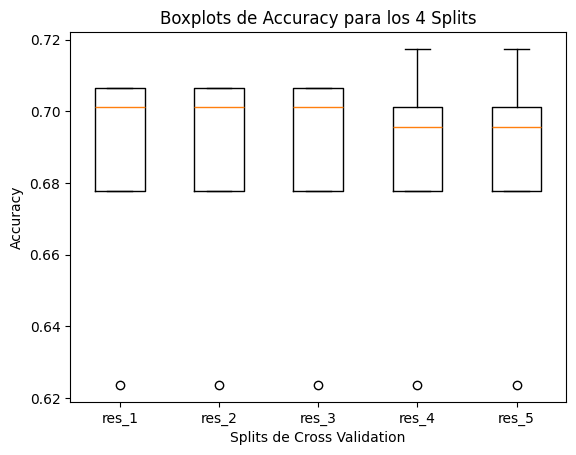

In [35]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

In [36]:
# modelo_GB = RandomForestClassifier(**sorted_results['params'].iloc[N],random_state=123) para el modelo N deseado
modelo_GB = grid_search_GB.best_estimator_

y_train_pred_gb = modelo_GB.predict(X_train)
y_test_pred_gb = modelo_GB.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred_gb)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred_gb)}')
print('Nótese la diferencia en accuracy para ambos conjuntos de datos se ha reducido en gran medida.')

Se tiene un accuracy para train de: 0.981029810298103
Se tiene un accuracy para test de: 0.6774193548387096
Nótese la diferencia en accuracy para ambos conjuntos de datos se ha reducido en gran medida.


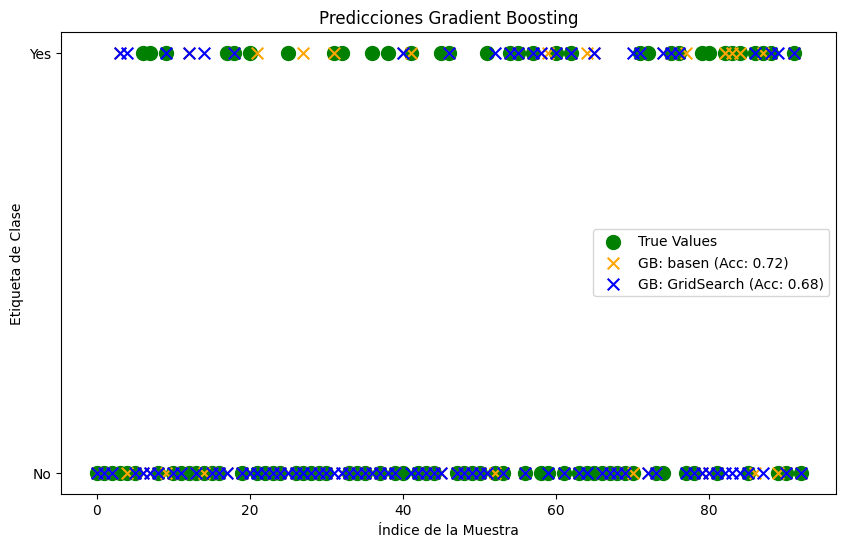

In [37]:
# Crear un gráfico de dispersión para comparar las predicciones
plt.figure(figsize=(10, 6))

plt.scatter(np.arange(len(y_test)), y_test, color='green', label='True Values', marker='o', s=100)
plt.scatter(np.arange(len(y_test)), y_pred_base, color='orange', label=f'GB: basen (Acc: {accuracy_a:.2f})', marker='x', s=70)
plt.scatter(np.arange(len(y_test)), y_test_pred_gb, color='blue', label=f'GB: GridSearch (Acc: {accuracy_score(y_test,y_test_pred_gb):.2f})', marker='x', s=70)

plt.title('Predicciones Gradient Boosting')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Etiqueta de Clase')
plt.legend()
plt.show()

In [38]:
print('Resultados para Modelo')
print(classification_report(y_test, y_test_pred_gb))

Resultados para Modelo
              precision    recall  f1-score   support

          No       0.72      0.82      0.77        60
         Yes       0.56      0.42      0.48        33

    accuracy                           0.68        93
   macro avg       0.64      0.62      0.62        93
weighted avg       0.66      0.68      0.67        93



A CONTINUACIÓN, SE REALIZARÁ EL EJEMPLO PARA EL CASO DE PROBLEMAS DE REGRESIÓN.

In [39]:
file_path_4 = 'compress.csv'

compress = pd.read_csv(file_path_4)
compress.head()

,cstrength,cement,blast,ash,water,plasti,aggreg,fineagg,age
0,79.99,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,61.89,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,40.27,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,41.05,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,44.30,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [40]:
# Separar las variables predictoras y la variable de respuesta.
X_c = compress.drop('cstrength', axis=1)
y_c = compress['cstrength']
gb_regressor = GradientBoostingRegressor(n_estimators = 450, subsample = 1, random_state = 123,n_iter_no_change = 10)
# Crear un conjunto de entrenamiento y uno de prueba
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=123)
# Construir el modelo de árbol de decisiones
gb_regressor.fit(X_train_c, y_train_c)

GradientBoostingRegressor(n_estimators=450, n_iter_no_change=10,
                          random_state=123, subsample=1)

In [41]:
#se valora el posible sobreajuste
pred_gb_c_train = gb_regressor.predict(X_train_c)
pred_gb_c_test = gb_regressor.predict(X_test_c)
print(f'MAE del modelo en train:{mean_absolute_error(y_train_c,pred_gb_c_train)}')
print(f'MAE del modelo en test:{mean_absolute_error(y_test_c,pred_gb_c_test)}')

MAE del modelo en train:1.9473618407402784
MAE del modelo en test:3.2203411186057003


In [42]:
# En caso de necesitar probar diferentes parametrizaciones. En este caso, iremos directamente a la validación cruzada.
params_c = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
# Definir las métricas de evaluación que deseas utilizar



In [43]:
scoring_metrics_c = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}
# los parámetros necesitan presentar formato lista.
params = {
    'criterion': ['friedman_mse'], 
    'learning_rate': [0.1,0.3],
    'max_depth': [3,5,10], 
    'min_samples_leaf': [1,5], 
    'min_samples_split': [2,4],
    'n_estimators': [50,100,150],
    'random_state': [123]
}
grid_search_gb_c = GridSearchCV(estimator=gb_regressor, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics_c, refit='MAE')
grid_search_gb_c.fit(X_train_c, y_train_c)

GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(n_estimators=450,
                                                 n_iter_no_change=10,
                                                 random_state=123,
                                                 subsample=1),
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.1, 0.3], 'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100, 150],
                         'random_state': [123]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict')})

In [44]:
pd.DataFrame(grid_search_gb_c.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_learning_rate', 'param_max_depth',
       'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'param_random_state', 'params', 'split0_test_MAE',
       'split1_test_MAE', 'split2_test_MAE', 'split3_test_MAE',
       'mean_test_MAE', 'std_test_MAE', 'rank_test_MAE', 'split0_test_MSE',
       'split1_test_MSE', 'split2_test_MSE', 'split3_test_MSE',
       'mean_test_MSE', 'std_test_MSE', 'rank_test_MSE'],
      dtype='object')

In [45]:
# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results_c = pd.DataFrame(grid_search_gb_c.cv_results_).sort_values(by='mean_test_MAE', ascending=True).head(5)

In [46]:

res_1_c = sorted_results_c[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[0]
res_2_c = sorted_results_c[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[1]
res_3_c = sorted_results_c[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[2]

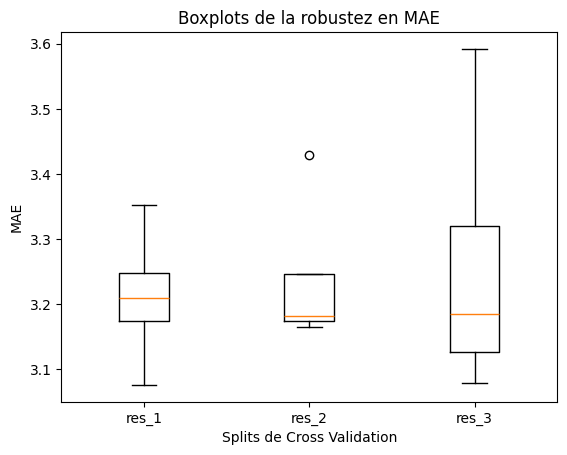

In [47]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1_c.values,res_2_c.values,res_3_c.values], labels = ['res_1','res_2','res_3'])
plt.title('Boxplots de la robustez en MAE')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('MAE')
plt.show()

In [48]:
# seleccionemos el segundo modelo dada su mayor robustez con respecto al propuesto por GridSearch
# nótese que "**" es para desempaquetar una lista de valores.
grid_search_gb_c_fin = GradientBoostingRegressor(**sorted_results_c['params'].iloc[1])
grid_search_gb_c_fin.fit(X_train_c, y_train_c)

GradientBoostingRegressor(max_depth=5, min_samples_split=4, n_estimators=150,
                          random_state=123)

In [49]:
#se valora el posible sobreajuste
pred_gb_c_train_fin = grid_search_gb_c_fin.predict(X_train_c)
pred_gb_c_test_fin = grid_search_gb_c_fin.predict(X_test_c)
print(f'MAE del modelo en train:{mean_absolute_error(y_train_c,pred_gb_c_train_fin)}')
print(f'MAE del modelo en test:{mean_absolute_error(y_test_c,pred_gb_c_test_fin)}')

MAE del modelo en train:1.0018394907267933
MAE del modelo en test:3.00669658607294


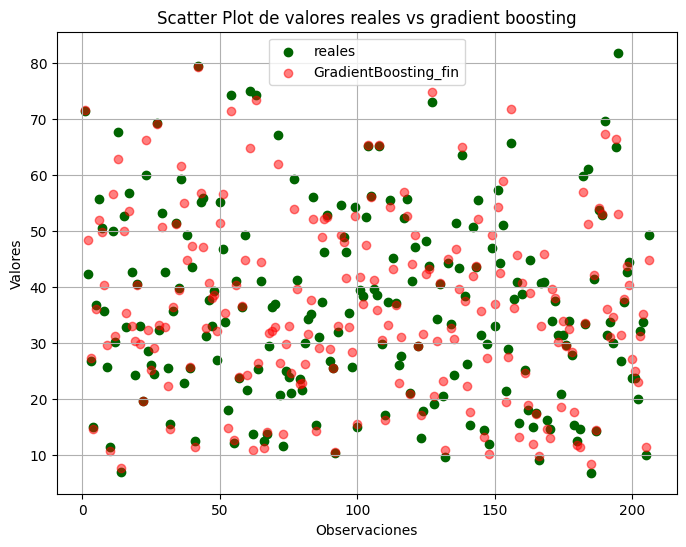

In [50]:
indices = np.arange(1, len(y_test_c) + 1)

plt.figure(figsize=(8, 6))
plt.scatter(indices, y_test_c, color='darkgreen', label='reales')  # Puedes ajustar el color según tus preferencias

plt.scatter(indices, pred_gb_c_test_fin, color='red', alpha=0.5, label='GradientBoosting_fin')  # Puedes ajustar el color y la transparencia según tus preferencias

plt.title('Scatter Plot de valores reales vs gradient boosting')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend()  # Agregar leyenda
plt.grid(True)
plt.show()

In [51]:
# Calcular diferentes medidas de bondad de ajuste
mae = mean_absolute_error(y_test_c, pred_gb_c_test_fin)
mse = mean_squared_error(y_test_c, pred_gb_c_test_fin)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_c, pred_gb_c_test_fin)

# Imprimir las métricas
print(f'MAE (Error Absoluto Medio): {mae:.2f}')
print(f'MSE (Error Cuadrático Medio): {mse:.2f}')
print(f'RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}')
print(f'R2: {r2}')

MAE (Error Absoluto Medio): 3.01
MSE (Error Cuadrático Medio): 22.42
RMSE (Raíz del Error Cuadrático Medio): 4.73
R2: 0.9183196289923017
